In [5]:
# 数据接口 
import akshare as ak
import baostock as bs
import tushare as ts

# 基础模块
import datetime
from itertools import product
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import time

# 回测框架
import backtrader as bt

# 基础函数
import utilsJ

# 策略

### 现有指标：
+ 均线 
+ 布林带
+ MACD柱状图
+ RSI相对强弱
+ WilliamR指标

In [15]:
class Strategy_comp_winrate(bt.Strategy):
    
    params = (
        # General params
        ('printlog', False),
        ('p_stake', 100),
        ('buy_signal', 'b'),
        ('sell_signal', 'b'),

        # Indicator params
        ('bollinger_per', 20),
        ('bollinger_dev', 2),
        ('rsi_short', 6),
        ('rsi_long', 12),
        ('wave_period', 7),
        ('wr', 14),
        
        # ATR params
        ('using_atr', False),
        ('atr_period', 14),
        ('atr_percent', 1),
    )
    
    
    def log(self, txt, dt=None, doprint=False):
        if self.params.printlog or doprint:
            dt = dt or self.datas[0].datetime.date(0)
            print('%s: %s' % (dt.isoformat(), txt))
            #with open('log.txt', 'a') as file:
                #file.write('%s: %s \n' % (dt.isoformat(), txt))
        
    
    def __init__(self):
        # Keep references to lines in the data[0] dataseries
        self.dataclose = self.datas[0].close
        self.datahigh = self.datas[0].high
        self.datalow = self.datas[0].low

        # Keep references to executed order & price
        self.buyprice = 0
        self.sellprice = 0
        self.order = None

        # Add indicators
        ## MACD indicator
        self.macdhisto = bt.indicators.MACDHisto(self.datas[0])
        self.macd_buy = bt.And(self.macdhisto.histo(0) > 0, self.macdhisto.histo(-1) < 0)
        self.macd_sell = bt.And(self.macdhisto.histo(0) < 0, self.macdhisto.histo(-1) > 0)
        
        ## Bollinger Bands indicator
        self.bolling = bt.indicators.BollingerBands(self.datas[0], 
                                                    period = self.params.bollinger_per, 
                                                    devfactor = self.params.bollinger_dev)
        self.bolling_buy = bt.Or(bt.And(self.dataclose(0) > self.bolling.top(0), self.dataclose(-1) < self.bolling.top(-1)), 
                                 bt.And(self.dataclose(0) > self.bolling.bot(0), self.dataclose(-1) < self.bolling.bot(-1)))
        self.bolling_sell = bt.Or(bt.And(self.dataclose(0) < self.bolling.top(0), self.dataclose(-1) > self.bolling.top(-1)), 
                                  bt.And(self.dataclose(0) < self.bolling.bot(0), self.dataclose(-1) > self.bolling.bot(-1)))

        ## RSI indicator
        self.rsi_s = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_short, safediv=True)
        self.rsi_l = bt.indicators.RelativeStrengthIndex(period=self.params.rsi_long, safediv=True)
        self.rsi_buy = bt.And(self.rsi_s(0) > self.rsi_l(0), self.rsi_s(-1) < self.rsi_l(-1))
        self.rsi_sell = bt.And(self.rsi_s(0) < self.rsi_l(0), self.rsi_s(-1) > self.rsi_l(-1))

        ## WilliamR indicator
        self.wr = bt.indicators.WilliamsR(period=self.params.wr)
        self.wr_buy = self.wr < -80
        self.wr_sell = self.wr > -20

        ## Wave indicator
        ### MovingAverageSimple indicator
        self.sma = bt.indicators.SimpleMovingAverage(self.datas[0], period=self.params.wave_period)
        self.wave_buy = bt.And(self.sma(0) > self.sma(-1), self.sma(-1) < self.sma(-2), self.sma(-2) < self.sma(-3))
        #self.wave_buy = self.sma(0) > self.bolling.mid(0),
        self.wave_sell = bt.And(self.sma(0) < self.sma(-1), self.sma(-1) > self.sma(-2), self.sma(-2) > self.sma(-3))
        #self.wave_sell = self.sma(0) < self.bolling.mid(0),

        
        
        ## ATR indicator
        self.atr_initial = self.broker.get_cash()
        self.tr = bt.indicators.Max((self.datahigh - self.datalow), 
                                    abs(self.dataclose(-1) - self.datahigh),
                                    abs(self.dataclose(-1) - self.datalow))
        self.atr = bt.indicators.SimpleMovingAverage(self.tr, period=self.params.atr_period)

        self.pos_trade = 0
        self.neg_trade = 0


    def notify_order(self, order):
        if order.status in [order.Submitted, order.Accepted]:
            # Buy/Sell order submitted/accepted to/by broker - Nothing to do
            return

        # Check if an order has been completed
        # Attention: broker could reject order if not enough cash
        if order.status in [order.Completed]:
            if order.isbuy():
                self.buyprice = order.executed.price
                self.log('BUY EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                         (order.executed.price,
                          order.executed.size,
                          self.broker.get_cash()))

            else:  # Sell
                self.sellprice = order.executed.price
                self.log('SELL EXECUTED, Price:%.2f, Lot:%i, Cash:%i.' %
                        (order.executed.price,
                          -order.executed.size,
                          self.broker.get_cash()))

        elif order.status in [order.Canceled, order.Margin, order.Rejected]:
            self.log('Order Canceled/Margin/Rejected')

        # Write down: no pending order
        #self.order = None


    def notify_trade(self, trade):
        if not trade.isclosed:
            return

        if trade.pnlcomm > 0:
            self.pos_trade += 1
        else:
            self.neg_trade += 1

        self.log('OPERATION PROFIT, GROSS %.2f, NET %.2f' %
                 (trade.pnl, trade.pnlcomm))
    

    def next(self):
        # Check if an order is pending ... if yes, we cannot send a 2nd one
        if self.order:
            return

        buy_indicator = (self.params.buy_signal == 'b' and self.bolling_buy) or \
                        (self.params.buy_signal == 'm' and self.macd_buy) or \
                        (self.params.buy_signal == 'w' and self.wave_buy) or \
                        (self.params.buy_signal == 'r' and self.rsi_buy) or \
                        (self.params.buy_signal == 'wr' and self.wr_buy)
                        
        sell_indicator = (self.params.sell_signal == 'b' and self.bolling_sell) or \
                         (self.params.sell_signal == 'm' and self.macd_sell) or \
                         (self.params.sell_signal == 'w' and self.wave_sell) or \
                         (self.params.sell_signal == 'r' and self.rsi_sell) or \
                         (self.params.sell_signal == 'wr' and self.wr_sell)
            
        if buy_indicator and self.dataclose[0] > self.bolling.mid[0]:
            if self.params.using_atr:
                opt_pos = np.round(self.atr_initial * self.params.atr_percent / self.params.p_stake / self.atr[0])
                if opt_pos*self.params.p_stake > 0 and self.getposition(self.data).size < opt_pos*self.params.p_stake:
                    self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                             (self.dataclose[0], 
                             opt_pos*self.params.p_stake-self.getposition(self.data).size,
                             self.getposition(self.data).size))
                    self.buy(size=opt_pos*self.params.p_stake-self.getposition(self.data).size)
                
                #elif opt_pos*self.params.p_stake > 0 and self.getposition(self.data).size > opt_pos*self.params.p_stake:
                #    self.log('SELL CREATE, Price: %.2f, Lots: %i, Current Position: %i' % 
                #            (self.dataclose[0], 
                #            self.getposition(self.data).size-opt_pos*self.params.p_stake,
                #            self.getposition(self.data).size))
                #    self.sell(size=self.getposition(self.data).size-opt_pos*self.params.p_stake)
            else:
                self.log('BUY CREATE, Price: %.2f, Lots: %i, Current Position: %i' % (self.dataclose[0], 
                        self.params.p_stake,
                        self.getposition(self.data).size))
                self.buy(size=self.params.p_stake)
        elif sell_indicator and self.getposition(self.data).size > 0:
            self.log('Sell CREATE(Close), Price: %.2f, Current Position: %i' % (self.dataclose[0],
                        self.getposition(self.data).size))
            self.close()


    def stop(self):
        self.log('Ending Position:%i. Ending Value:%.2f.' %
                (self.getposition(self.data).size,
                self.cerebro.broker.getvalue()), doprint=False)
        #if self.pos_trade != 0 or self.neg_trade != 0:
        #    print(self.pos_trade / (self.pos_trade + self.neg_trade))
        #else:
        #    print('no trade closed.')

### 沪深300循环回测

##### 获取最优策略

In [17]:
idx = '399300.SZ'

s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
e_date = datetime.date(2020,12,31)

pro = ts.pro_api('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
index_list = np.unique(pro.index_weight(index_code=idx,
                                        start_date=s_date.strftime('%Y%m%d'),
                                        end_date=e_date.strftime('%Y%m%d')).con_code).tolist()
buy_s = ['b','m','w', 'r', 'wr']
sell_s = ['b','m','w', 'r', 'wr']

if __name__ == '__main__':
    profit_stk = dict()
    for stk in index_list:
        profit_ind = dict()
        for s in product(*[buy_s, sell_s]):

            # Create a cerebro entity
            cerebro = bt.Cerebro()

            # Add a strategy
            strats = cerebro.addstrategy(Strategy_comp_winrate, printlog=False, using_atr=True, atr_percent=0.02, buy_signal = s[0], sell_signal = s[1]) 

            s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
            e_date = datetime.date(2020,12,31)

            # Create stock Data Feed
            #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
            #                    stock_index, s_date, e_date)
            df = pd.read_csv('.\\Data\\2019\\'+stk+'.csv', 
                            converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
            data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

            # Add the index Data Feed to Cerebo
            cerebro.adddata(data)

            # Set cash inside the strategy
            cerebro.broker = bt.brokers.BackBroker(coc=True)   
            cerebro.broker.setcash(500000)

            # Set commission
            #cerebro.broker.setcommission()

            # Print out the starting conditions
            start_value = cerebro.broker.getvalue()
            #print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

            # Run over everything
            cerebro.run()

            # Print out the final result
            final_value = cerebro.broker.getvalue()
            #print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
            #print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))
            profit_ind[s] = (final_value - start_value) / start_value * 100
        print((stk, sorted(profit_ind.items(), key=lambda x: x[1], reverse=True)[:3]))
        profit_stk[stk] = sorted(profit_ind.items(), key=lambda x: x[1], reverse=True)

('000001.SZ', [(('w', 'b'), 23.5062), (('w', 'r'), 12.5706), (('b', 'wr'), 12.295399999999999)])
('000002.SZ', [(('r', 'wr'), 15.613399999999999), (('r', 'b'), 12.7052), (('m', 'wr'), 9.9182)])
('000063.SZ', [(('m', 'w'), 5.8854), (('m', 'r'), 5.2892), (('b', 'b'), 4.2184)])
('000066.SZ', [(('b', 'r'), 17.991), (('r', 'm'), 15.436), (('r', 'w'), 15.3128)])
('000069.SZ', [(('m', 'm'), 15.6614), (('r', 'b'), 13.750000000000002), (('w', 'b'), 12.3432)])
('000100.SZ', [(('r', 'b'), 26.491799999999998), (('m', 'b'), 17.501), (('w', 'b'), 13.442799999999998)])
('000157.SZ', [(('r', 'w'), 36.1524), (('b', 'r'), 28.0906), (('b', 'b'), 27.7482)])
('000166.SZ', [(('b', 'b'), 17.5162), (('b', 'r'), 13.059000000000001), (('b', 'w'), 9.6836)])
('000333.SZ', [(('b', 'm'), 30.6124), (('m', 'm'), 25.501000000000047), (('w', 'm'), 19.4298)])
('000338.SZ', [(('m', 'b'), 20.2716), (('m', 'wr'), 19.893), (('m', 'w'), 18.3758)])
('000413.SZ', [(('m', 'wr'), 12.683), (('r', 'wr'), 2.6532), (('w', 'wr'), 1.6

('002555.SZ', [(('m', 'b'), 5.6384), (('m', 'r'), 4.8238), (('b', 'r'), 4.252800000000001)])
('002558.SZ', [(('w', 'm'), 20.3084), (('b', 'm'), 19.4798), (('b', 'wr'), 16.5426)])
('002594.SZ', [(('w', 'm'), 96.7576), (('m', 'm'), 91.3382), (('r', 'm'), 80.7022)])
('002600.SZ', [(('w', 'wr'), 21.3198), (('r', 'wr'), 15.859000000000002), (('w', 'b'), 11.936)])
('002601.SZ', [(('r', 'r'), 25.085), (('r', 'm'), 21.944800000000022), (('r', 'wr'), 15.25)])
('002602.SZ', [(('r', 'wr'), 7.7951999999999995), (('w', 'wr'), 3.559600000000011), (('b', 'wr'), 3.2376)])
('002607.SZ', [(('r', 'wr'), 15.976), (('w', 'm'), 14.5582), (('b', 'm'), 14.2556)])
('002624.SZ', [(('m', 'wr'), 6.1532), (('m', 'r'), 5.1484000000000005), (('b', 'r'), 4.3038)])
('002673.SZ', [(('r', 'b'), 29.507), (('r', 'r'), 22.889), (('b', 'b'), 15.9336)])
('002714.SZ', [(('b', 'm'), 1.3452), (('b', 'w'), 0.8808), (('b', 'r'), 0.5004)])
('002736.SZ', [(('m', 'wr'), 16.0758), (('r', 'r'), 15.424199999999999), (('r', 'wr'), 12.56

('600276.SH', [(('r', 'm'), 21.4272), (('r', 'wr'), 12.828800000000001), (('b', 'm'), 6.6596)])
('600297.SH', [(('m', 'b'), 8.072), (('m', 'r'), 6.5066), (('r', 'w'), 5.752800000000001)])
('600299.SH', [(('r', 'b'), 11.0694), (('r', 'w'), 9.5332), (('r', 'm'), 6.0094)])
('600309.SH', [(('r', 'm'), 36.0284), (('m', 'w'), 34.1556), (('w', 'm'), 32.89619999999995)])
('600332.SH', [(('w', 'wr'), 9.063400000000001), (('w', 'b'), 7.2076), (('m', 'b'), 4.808399999999988)])
('600340.SH', [(('r', 'wr'), 16.6744), (('b', 'wr'), 4.133600000000012), (('m', 'wr'), 1.1381999999999883)])
('600346.SH', [(('w', 'm'), 21.5474), (('r', 'b'), 20.516000000000002), (('w', 'b'), 20.281)])
('600352.SH', [(('r', 'b'), 17.8714), (('r', 'wr'), 17.826), (('m', 'b'), 13.8684)])
('600362.SH', [(('b', 'm'), 32.1048), (('r', 'm'), 22.85), (('b', 'r'), 17.400399999999998)])
('600369.SH', [(('r', 'r'), 19.700799999999997), (('b', 'w'), 16.2988), (('r', 'b'), 15.1842)])
('600372.SH', [(('b', 'wr'), 5.8342), (('m', 'w'),

('601212.SH', [(('w', 'wr'), 8.1646), (('b', 'w'), 7.6882), (('w', 'w'), 6.764)])
('601216.SH', [(('b', 'm'), 212.07580000000004), (('b', 'w'), 185.80239999999998), (('r', 'm'), 68.904)])
('601225.SH', [(('m', 'w'), 11.5002), (('b', 'w'), 8.9764), (('m', 'm'), 7.9204)])
('601229.SH', [(('b', 'b'), 0.0), (('b', 'm'), 0.0), (('b', 'w'), 0.0)])
('601231.SH', [(('m', 'b'), 15.9916), (('r', 'b'), 8.825), (('w', 'b'), 7.007200000000023)])
('601236.SH', [(('b', 'wr'), 10.8642), (('b', 'r'), 9.9692), (('b', 'b'), 5.8144)])
('601238.SH', [(('r', 'wr'), 19.0498), (('r', 'r'), 9.8318), (('r', 'w'), 9.315199999999999)])
('601288.SH', [(('b', 'b'), 0.0), (('b', 'm'), 0.0), (('b', 'w'), 0.0)])
('601298.SH', [(('r', 'w'), 3.9984000000000117), (('r', 'b'), 3.9916), (('wr', 'r'), 3.6008)])
('601318.SH', [(('w', 'b'), 8.1914), (('m', 'b'), 8.1868), (('r', 'wr'), 7.8332)])
('601319.SH', [(('b', 'b'), 18.5744), (('b', 'r'), 14.552999999999999), (('r', 'r'), 14.433000000000002)])
('601328.SH', [(('b', 'b')

In [10]:
import json
with open('.\\Data\\综合策略1号-个股胜率-Profit.txt', 'w') as f:
    json.dump(profit_stk, f)
#profit_stk = json.load(':\\Data\\综合策略1号-个股胜率-Profit.txt')

##### 获取最优策略胜率

In [25]:
np.mean([x[0][1] for x in profit_stk.values()])
profit_sig = dict()
for v in profit_stk.values():
    if v[0][0] not in profit_sig.keys():
        profit_sig[v[0][0]] = 1
    else:
        profit_sig[v[0][0]] += 1
print(profit_sig)


{('w', 'b'): 24, ('r', 'wr'): 27, ('m', 'w'): 12, ('b', 'r'): 11, ('m', 'm'): 15, ('r', 'b'): 41, ('r', 'w'): 20, ('b', 'b'): 27, ('b', 'm'): 15, ('m', 'b'): 27, ('m', 'wr'): 19, ('b', 'wr'): 19, ('w', 'm'): 19, ('r', 'r'): 15, ('w', 'w'): 7, ('m', 'r'): 8, ('w', 'wr'): 12, ('w', 'r'): 6, ('r', 'm'): 17, ('wr', 'b'): 4, ('b', 'w'): 2}


In [31]:
profit_stk['000001.SZ'][0][0][0]

'w'

### 个股胜率测试

In [33]:
idx = '399300.SZ'

s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
e_date = datetime.date(2020,12,31)

#pro = ts.pro_api('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6')
#index_list = np.unique(pro.index_weight(index_code=idx,
#                                        start_date=s_date.strftime('%Y%m%d'),
#                                        end_date=e_date.strftime('%Y%m%d')).con_code).tolist()

if __name__ == '__main__':
    for stk in index_list:
        # Create a cerebro entity
        cerebro = bt.Cerebro()

        # Add a strategy
        strats = cerebro.addstrategy(Strategy_comp_winrate, printlog=False, using_atr=True, 
                                     atr_percent=0.02, buy_signal=profit_stk[stk][0][0][0], 
                                     sell_signal=profit_stk[stk][0][0][1]) 

        s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
        e_date = datetime.date(2020,12,31)

        # Create stock Data Feed
        #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
        #                    stock_index, s_date, e_date)
        df = pd.read_csv('.\\Data\\2019\\'+stk+'.csv', 
                        converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
        data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

        # Add the index Data Feed to Cerebo
        cerebro.adddata(data)

        # Set cash inside the strategy
        cerebro.broker = bt.brokers.BackBroker(coc=True)   
        cerebro.broker.setcash(1000000)

        # Set commission
        #cerebro.broker.setcommission()

        # Print out the starting conditions
        start_value = cerebro.broker.getvalue()
        print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

        # Run over everything
        cerebro.run()

        # Print out the final result
        final_value = cerebro.broker.getvalue()
        print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
        print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))
        

Starting Portfolio Value: 1000000.00
0.8333333333333334
Final Portfolio Value: 1235047.00
Net Profit: 23.50%
Starting Portfolio Value: 1000000.00
0.75
Final Portfolio Value: 1156134.00
Net Profit: 15.61%
Starting Portfolio Value: 1000000.00
0.6666666666666666
Final Portfolio Value: 1059782.00
Net Profit: 5.98%
Starting Portfolio Value: 1000000.00
0.5
Final Portfolio Value: 1180058.00
Net Profit: 18.01%
Starting Portfolio Value: 1000000.00
0.3333333333333333
Final Portfolio Value: 1156745.00
Net Profit: 15.67%
Starting Portfolio Value: 1000000.00
1.0
Final Portfolio Value: 1264835.00
Net Profit: 26.48%
Starting Portfolio Value: 1000000.00
0.8
Final Portfolio Value: 1361515.00
Net Profit: 36.15%
Starting Portfolio Value: 1000000.00
0.25
Final Portfolio Value: 1175159.00
Net Profit: 17.52%
Starting Portfolio Value: 1000000.00
0.8
Final Portfolio Value: 1305660.00
Net Profit: 30.57%
Starting Portfolio Value: 1000000.00
0.8
Final Portfolio Value: 1202736.00
Net Profit: 20.27%
Starting Portf

# 单股回测

In [13]:
if __name__ ==  '__main__':
    # Create a cerebro entity
    cerebro = bt.Cerebro()

    # Add a strategy
    strats = cerebro.addstrategy(Strategy_comp_winrate, printlog=True, using_atr=True, atr_percent=0.01, buy_signal = 'm', sell_signal = 'm') 

    s_date = datetime.date(2020,12,31) - datetime.timedelta(days=385)
    e_date = datetime.date(2020,12,31)

    # Create stock Data Feed
    stock_index = '601216.SH'
    #df = utilsJ.stock_tushare('74f1379591c9d810854fa5891fffcacaba514b82bf17ec2e239025b6', 
    #                    stock_index, s_date, e_date)
    df = pd.read_csv('.\\Data\\2019\\' + stock_index + '.csv', converters={'trade_date':lambda x:pd.to_datetime(x)}).set_index('trade_date')
    data = bt.feeds.PandasData(dataname=df,fromdate=s_date,todate=e_date)

    # Add the index Data Feed to Cerebo
    cerebro.adddata(data)

    # Set cash inside the strategy
    cerebro.broker = bt.brokers.BackBroker(coc=True)   
    cerebro.broker.setcash(1000000)

    # Set commission
    #cerebro.broker.setcommission()

    # Print out the starting conditions
    start_value = cerebro.broker.getvalue()
    print('Starting Portfolio Value: %.2f' % cerebro.broker.getvalue())

    # Run over everything
    cerebro.run()

    # Print out the final result
    final_value = cerebro.broker.getvalue()
    print('Final Portfolio Value: %.2f' % cerebro.broker.getvalue())
    print('Net Profit: %.2f%%' % ((final_value - start_value) / start_value * 100))

Starting Portfolio Value: 1000000.00
2020-02-17: BUY CREATE, Price: 2.87, Lots: 89200, Current Position: 0
2020-02-18: BUY EXECUTED, Price:2.87, Lot:89200, Cash:743996.
2020-03-10: Sell CREATE(Close), Price: 2.78, Current Position: 89200
2020-03-11: SELL EXECUTED, Price:2.78, Lot:89200, Cash:991972.
2020-03-11: OPERATION PROFIT, GROSS -8028.00, NET -8028.00
2020-05-20: BUY CREATE, Price: 2.96, Lots: 150500, Current Position: 0
2020-05-21: BUY EXECUTED, Price:2.96, Lot:150500, Cash:546492.
2020-05-26: Sell CREATE(Close), Price: 2.55, Current Position: 150500
2020-05-27: SELL EXECUTED, Price:2.55, Lot:150500, Cash:930267.
2020-05-27: OPERATION PROFIT, GROSS -61705.00, NET -61705.00
2020-08-19: BUY CREATE, Price: 10.38, Lots: 8900, Current Position: 0
2020-08-20: BUY EXECUTED, Price:10.38, Lot:8900, Cash:837885.
2020-08-20: Sell CREATE(Close), Price: 9.34, Current Position: 8900
2020-08-21: SELL EXECUTED, Price:9.34, Lot:8900, Cash:921011.
2020-08-21: OPERATION PROFIT, GROSS -9256.00, NET

<IPython.core.display.Javascript object>


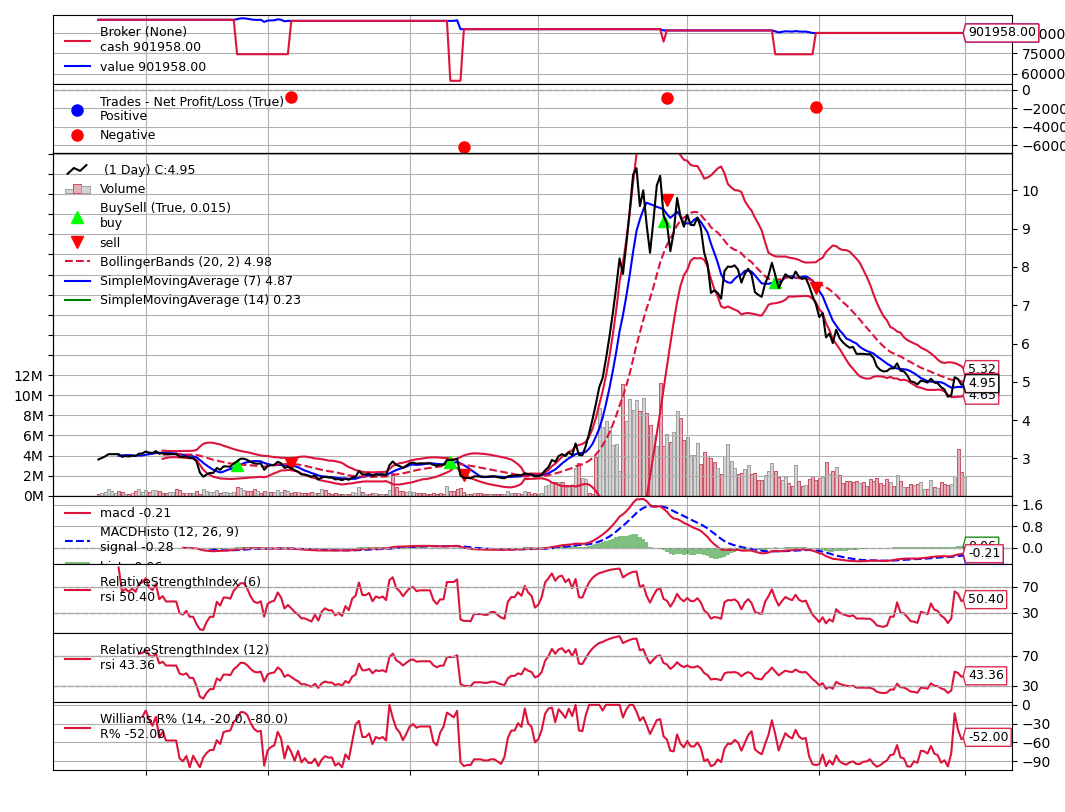

[[<Figure size 640x480 with 8 Axes>]]

In [14]:
cerebro.plot()